# Matching Line P bottle data to Line P CTD
basically the bottle data i got has density but no temperature and salinity... so i want to get the temperature and salnity from CTD measurements taken at the same time, and use the density to confirm that I did this correctly

In [1]:
import pandas as pd
import numpy as np
import gsw
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
bot = pd.read_csv("/data1/bbeutel/LO_user/tracers/TM_LineP_2012-2020_RobynTaves.csv").drop([0], axis=0).reset_index().drop(['index'], axis=1)
bot.head()

,Cruise ID,Season,Month,Station ID,Event ID,Start Date (UTC),Start Time (UTC),Start Latitude,Start Longitude,Sample ID,...,Flag::Ni_D_CONC_BOTTLE,Cu_D_CONC_BOTTLE,1SD::Cu_D_CONC_BOTTLE,Flag::Cu_D_CONC_BOTTLE,Zn_D_CONC_BOTTLE,1SD::Zn_D_CONC_BOTTLE,Flag::Zn_D_CONC_BOTTLE,Cd_D_CONC_BOTTLE,1SD::Cd_D_CONC_BOTTLE,Flag::Cd_D_CONC_BOTTLE
0,2012-01,Winter,february_2012,P26,48.0,15-02-2012,17:30,50,-145,420,...,1.0,1.59,0.01,1.0,0.78,0.01,1.0,0.44,0.01,1.0
1,2012-01,Winter,february_2012,P26,48.0,15-02-2012,17:30,50,-145,419,...,1.0,1.57,0.01,1.0,0.77,0.01,1.0,0.448,0.005,1.0
2,2012-01,Winter,february_2012,P26,48.0,15-02-2012,17:30,50,-145,418,...,1.0,1.83,0.04,1.0,0.75,0.02,1.0,0.44,0.02,1.0
3,2012-01,Winter,february_2012,P26,45.0,15-02-2012,15:45,50,-145,393,...,1.0,1.808,0.009,1.0,1.12,0.03,1.0,0.451,0.004,1.0
4,2012-01,Winter,february_2012,P26,45.0,15-02-2012,15:45,50,-145,391,...,1.0,1.74,0.01,1.0,2.81,0.02,1.0,0.46,0.01,1.0


In [3]:
ctd = pd.read_csv('/data1/bbeutel/LO_user/tracers/IOS_CTD_Profiles_fd34_9c4c_aad5.csv').drop([0], axis=0)
ctd.head()

/tmp/ipykernel_21514/417979086.py:1: DtypeWarning: Columns (6,7,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  ctd = pd.read_csv('/data1/bbeutel/LO_user/tracers/IOS_CTD_Profiles_fd34_9c4c_aad5.csv').drop([0], axis=0)


,profile,mission_id,scientist,project,agency,platform,latitude,longitude,time,depth,sea_water_temperature,sea_water_practical_salinity,sea_water_pressure
1,2012-013-0001,2012-013,Robert M.,Line P,"IOS, Ocean Sciences Division, Sidney, B.C.",John P. Tully,48.593166,-123.499664,2012-08-15T21:33:04Z,3.0738006,16.8088,25.6253,3.1
2,2012-013-0001,2012-013,Robert M.,Line P,"IOS, Ocean Sciences Division, Sidney, B.C.",John P. Tully,48.593166,-123.499664,2012-08-15T21:33:04Z,3.9661856,16.7533,25.6583,4.0
3,2012-013-0001,2012-013,Robert M.,Line P,"IOS, Ocean Sciences Division, Sidney, B.C.",John P. Tully,48.593166,-123.499664,2012-08-15T21:33:04Z,4.95772,16.5751,25.723,5.0
4,2012-013-0001,2012-013,Robert M.,Line P,"IOS, Ocean Sciences Division, Sidney, B.C.",John P. Tully,48.593166,-123.499664,2012-08-15T21:33:04Z,5.9492497,16.5679,25.8163,6.0
5,2012-013-0001,2012-013,Robert M.,Line P,"IOS, Ocean Sciences Division, Sidney, B.C.",John P. Tully,48.593166,-123.499664,2012-08-15T21:33:04Z,6.9407744,16.7775,25.8765,7.0


In [4]:
ctd['date'] = [d.date() for d in pd.to_datetime(ctd['time'])]
bot['date'] = [d.date() for d in pd.to_datetime(bot['Start Date (UTC)'])]

/tmp/ipykernel_21514/212731617.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  bot['date'] = [d.date() for d in pd.to_datetime(bot['Start Date (UTC)'])]


In [5]:
ctd_dates = set(ctd.date)
bot_dates = set(bot.date)
match_count = [len(ctd[ctd.date==d]) for d in bot_dates]
np.count_nonzero(match_count)
# ok so only 7 out of 87 days with bottle data are missing CTD casts

80

In [11]:
# Ensure latitude, longitude, and depth columns are in float format
bot['Start Latitude'] = bot['Start Latitude'].astype(float)
bot['Start Longitude'] = bot['Start Longitude'].astype(float)
bot['Depth'] = bot['Depth'].astype(float)

ctd['latitude'] = ctd['latitude'].astype(float)
ctd['longitude'] = ctd['longitude'].astype(float)
ctd['depth'] = ctd['depth'].astype(float)

In [13]:
# Function to find the closest match (with 10 m depth threshold)
def closest_match(row, df, threshold=10):
    date = row['date']
    latitude = row['Start Latitude']
    longitude = row['Start Longitude']
    depth = row['Depth']
    
    # Filter by date first
    df_filtered = df[df['date'] == date]
    
    if df_filtered.empty:
        return pd.Series({'sea_water_temperature': np.nan, 'sea_water_practical_salinity': np.nan})
    
    # Calculate distance metric (latitude, longitude, depth)
    df_filtered['distance'] = ((df_filtered['latitude'] - latitude)**2 + 
                               (df_filtered['longitude'] - longitude)**2 + 
                               (df_filtered['depth'] - depth)**2)**0.5
    
    # Get the closest match within the depth threshold
    closest = df_filtered.loc[df_filtered['distance'].idxmin()]
    
    if abs(closest['depth'] - depth) > threshold:
        return pd.Series({'sea_water_temperature': np.nan, 'sea_water_practical_salinity': np.nan,
                          'depth':np.nan})
    else:
        return pd.Series({'sea_water_temperature': closest['sea_water_temperature'], 
                          'sea_water_practical_salinity': closest['sea_water_practical_salinity'],
                          'depth': closest['depth']})

# Apply the closest_match function to each row of 'bot'
result = bot.apply(lambda row: closest_match(row, ctd), axis=1)

# Merge the result with the original 'bot' dataframe
bot = pd.concat([bot, result], axis=1)

bot

,Cruise ID,Season,Month,Station ID,Event ID,Start Date (UTC),Start Time (UTC),Start Latitude,Start Longitude,Sample ID,...,Zn_D_CONC_BOTTLE,1SD::Zn_D_CONC_BOTTLE,Flag::Zn_D_CONC_BOTTLE,Cd_D_CONC_BOTTLE,1SD::Cd_D_CONC_BOTTLE,Flag::Cd_D_CONC_BOTTLE,date,depth,sea_water_practical_salinity,sea_water_temperature
0,2012-01,Winter,february_2012,P26,48.0,15-02-2012,17:30,50.00,-145.00,420,...,0.78,0.01,1.0,0.44,0.01,1.0,2012-02-15,NaN,NaN,NaN
1,2012-01,Winter,february_2012,P26,48.0,15-02-2012,17:30,50.00,-145.00,419,...,0.77,0.01,1.0,0.448,0.005,1.0,2012-02-15,NaN,NaN,NaN
2,2012-01,Winter,february_2012,P26,48.0,15-02-2012,17:30,50.00,-145.00,418,...,0.75,0.02,1.0,0.44,0.02,1.0,2012-02-15,NaN,NaN,NaN
3,2012-01,Winter,february_2012,P26,45.0,15-02-2012,15:45,50.00,-145.00,393,...,1.12,0.03,1.0,0.451,0.004,1.0,2012-02-15,NaN,NaN,NaN
4,2012-01,Winter,february_2012,P26,45.0,15-02-2012,15:45,50.00,-145.00,391,...,2.81,0.02,1.0,0.46,0.01,1.0,2012-02-15,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,2020-008,Summer,august_2020,P4,87.0,24-08-2020,7:49,48.65,-126.67,449,...,3.42,0.02,1.0,0.58,0.01,1.0,2020-08-24,99.7,32.9094,7.6758
553,2020-008,Summer,august_2020,P4,87.0,24-08-2020,7:49,48.65,-126.67,448,...,2.082,0.009,1.0,0.563,0.005,1.0,2020-08-24,150.3,33.7817,7.311
554,2020-008,Summer,august_2020,P4,87.0,24-08-2020,7:49,48.65,-126.67,147,...,2.77,0.02,1.0,0.581,0.004,1.0,2020-08-24,199.8,33.9002,6.932
555,2020-008,Summer,august_2020,P4,87.0,24-08-2020,7:49,48.65,-126.67,446,...,4.36,0.03,1.0,0.646,0.005,1.0,2020-08-24,399.7,34.0124,5.3226


In [14]:
# lets calculate the density and see how well it matches to the already calculated density
SA = gsw.SA_from_SP(np.array(bot.sea_water_practical_salinity), np.array(bot.Depth), np.array(bot['Start Longitude']), np.array(bot['Start Latitude']))
CT = gsw.conversions.CT_from_t(SA, np.array(bot.sea_water_temperature), np.array(bot.Depth))
rho=gsw.density.rho(SA, CT, np.array(bot.Depth))

In [15]:
def calc_stats(x, y):
    stat = {}
    x_new = x[np.isfinite(x)]
    y_new = y[np.isfinite(x)]
    x = x_new[np.isfinite(y_new)]
    y = y_new[np.isfinite(y_new)]

    MSE = np.mean((y - x)**2)
    stat['RMSE'] = np.sqrt(MSE)
    stat['bias'] = np.mean(y) - np.mean(x)
    stat['WSS'] = 1 - MSE / np.mean((abs(y - np.mean(x)) + abs(x - np.mean(x)))**2)
    stat['r'] = stats.pearsonr(x,y).statistic
    
    return stat

def plot_panel(ax, x, y, lims, units):
    stats = calc_stats(x, y)

    statstext = f"RMSE = {stats['RMSE']:.3f} {units}\nbias = {stats['bias']:.3f} {units}\nWSS = {stats['WSS']:.3f}\nr = {stats['r']:.3f}"
    
    props = dict(boxstyle='round', facecolor='w', alpha=0.9)
    c = ax.text(0.5, 0.04, statstext, bbox=props, transform=ax.transAxes, fontsize=9)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    return c

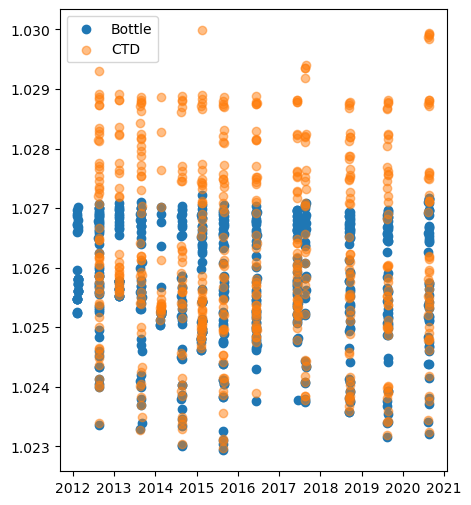

In [16]:
# density compare
fig, ax = plt.subplots(1,1,figsize=[5,6])

ax.scatter(np.array(bot.date),np.array(bot.Density.astype(float)),label='Bottle')
ax.scatter(np.array(bot.date),rho/1000,label='CTD',alpha=0.5)

ax.legend()

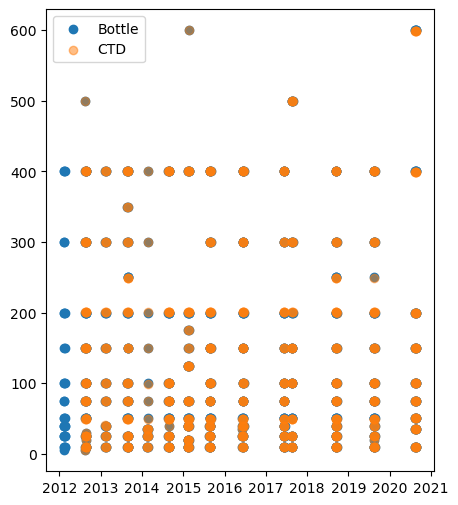

In [17]:
# make sure depth is close
fig, ax = plt.subplots(1,1,figsize=[5,6])

ax.scatter(np.array(bot.date),np.array(bot.Depth),label='Bottle')
ax.scatter(np.array(bot.date),bot.depth,label='CTD',alpha=0.5)

ax.legend()